# **Modeling Notebook**

- This Notebook will be used for testing different models which will then be included in the final Vignette report.

We will be testing the following models:
- **Simple CNN**
    - 3 Convolution Layers with 64 filters for the first 2 and 128 for the second,
    - Maxpooling
    - and a Dense Layer with 128 nodes with a dropout of 50%
- **Hyperband Parameter Training**
    - Uses Keras Hyperband Tuning to start with different architectures at lower epochs and slowly removes unpromising setups, and keeps the best ones and trains further
- **Bayesian Optimization**
    - Uses Optuna to efficiently search the hyperparameter space by modeling the objective function and selecting hyperparameters that are expected to improve the model's performance. This approach is particularly useful for optimizing complex models with many hyperparameters.
- Pre-trained Model additional layering
    - on top of convolution layers to improve 
    - by how much does it improve

Considerations:
- Do we need to consider a better data set?
- how can we get better performance?

In [6]:
##### library imports ##### 

# preprocessing and splitting data packages
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
# modeling data packages
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import optuna # for bayesian optimization

# set random seeds
np.random.seed(12345)
tf.random.set_seed(12345)
keras.utils.set_random_seed(12345)

# Preprocess Data from Preprocessing file

- Pulls 400 Brain Tumor MRI images from each of 4 different classes, including:
    - Glioma
    - Meningioma  
    - Pituitary
    - Normal (no tumor)

- Ensures they are normalizes, resized, and Grayscaled for quicker computation

In [7]:
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 500 # more than 600 in each class
seed = 1234 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
print("processed glioma data")
print(glioma_data.shape)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
print("processed meningioma data")
print(meningioma_data.shape)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
print("processed pituitary data")
print(pituitary_data.shape)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
print("processed normal data")
print(normal_data.shape)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/glioma_tumor: 901
Selected files: 500
Processed 500 images.
processed glioma data
(500, 64, 64, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/meningioma_tumor: 913
Selected files: 500
Processed 500 images.
processed meningioma data
(500, 64, 64, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/pituitary_tumor: 843
Selected files: 500
Processed 500 images.
processed pituitary data
(500, 64, 64, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/normal_tumor: 633
Selected files: 500
Processed 500 images.
processed normal data
(500, 64, 64, 1)
All data have the same shape
Combined data and labels shape: (2000, 64, 64, 1), (2000,)


# Visually Inspect

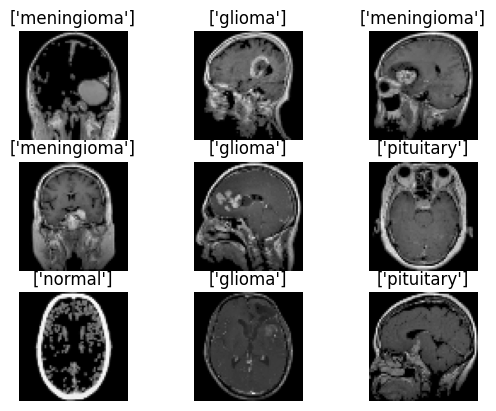

In [8]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- ### We first can start with a simple convolution model as a base level to see how well one archictecture will learn on the training data set.
- ### Next, we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.
     - Hyperband tuning performs a combination of random search and early stopping to efficiently explore hyperparameter configurations. It allocates resources to promising configurations while quickly discarding those that are underperforming, allowing for faster convergence to optimal hyperparameters.

# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [11]:
# Initialize model
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Flatten(), # flatten the data to feed into the dense layers
  Dense(units=128, activation='relu'),
  Dropout(0.5), # prevent overfitting
  Dense(units=4, activation='softmax') # output layer
])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,286,404 (12.54 MB)

 Trainable params: 3,286,404 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3011 - loss: 1.4089 - val_accuracy: 0.4844 - val_loss: 1.1538
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5055 - loss: 1.1382 - val_accuracy: 0.6469 - val_loss: 0.9432
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6485 - loss: 0.8958 - val_accuracy: 0.6781 - val_loss: 0.8610
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7121 - loss: 0.7519 - val_accuracy: 0.7219 - val_loss: 0.8009
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7456 - loss: 0.6316 - val_accuracy: 0.7281 - val_loss: 0.7580
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8006 - loss: 0.5711 - val_accuracy: 0.7250 - val_loss: 0.7740
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8344 - loss: 0.4654 - val_accuracy: 0.8031 - val_loss: 0.6731
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8364 - loss: 0.4367 - val_accuracy: 0.8062 - v

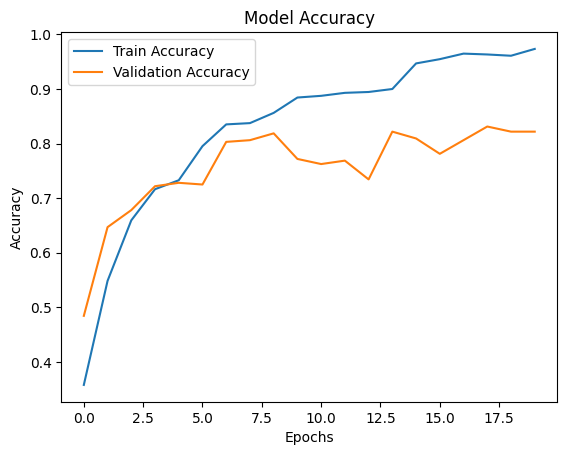

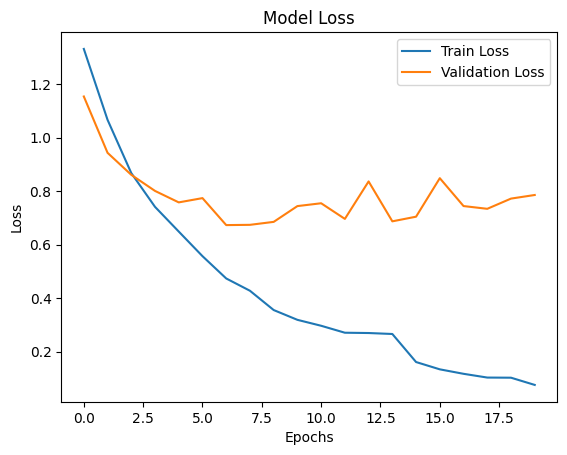

In [12]:
# Train the model # 

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    train_data,
    train_labels,
    validation_split=0.2, # Convert sparse matrix
    epochs=20,
    batch_size=32, # mini batch size
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- We will apply Hyperband Parameter Tuning to find our best set of params
- Then once we have the best set of hyperparams, we will build a final model and train with those parameters on the full training set.

In [13]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    # initialize the model
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
               activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
               activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
               kernel_size=3,
               activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(4, activation='softmax')
    ])
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
# initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=5,
    directory=my_dir[:-15] + "/scripts/drafts/model_trials",  # Use temporary directory
    project_name='hp_tuning',
    overwrite=False
)
# search for the best hyperparameters
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
tuner.search(
    train_small, train_small_labels,
    epochs=5,
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping],
    verbose=1
)
# Get the best hyperparameters directly
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)
# build the best model
final_model = tuner.hypermodel.build(best_hp)
final_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
final_model.summary()

Trial 59 Complete [00h 02m 47s]
val_accuracy: 0.8174999952316284

Best val_accuracy So Far: 0.8725000023841858
Total elapsed time: 00h 22m 30s
Best Hyperparameters:
{'conv_1_filter': 80, 'conv_1_kernel': 5, 'conv_2_filter': 64, 'conv_2_kernel': 3, 'conv_3_filter': 96, 'dense_1_units': 224, 'dropout_1': 0.30000000000000004, 'tuner/epochs': 30, 'tuner/initial_epoch': 6, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0045'}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 80)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        46,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │       774,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,884 (3.35 MB)

 Trainable params: 878,884 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

Once we have our best model, we can then build using the best architecture and train on the full data set.

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2617 - loss: 1.3830 - val_accuracy: 0.4875 - val_loss: 1.1930
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5270 - loss: 1.1245 - val_accuracy: 0.5917 - val_loss: 1.0621
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6092 - loss: 0.9227 - val_accuracy: 0.6625 - val_loss: 0.9315
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6972 - loss: 0.8214 - val_accuracy: 0.7250 - val_loss: 0.8215
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7433 - loss: 0.7098 - val_accuracy: 0.6708 - val_loss: 0.8557
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7949 - loss: 0.5818 - val_accuracy: 0.7542 - val_loss: 0.7165
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8331 - loss: 0.4746 - val_accuracy: 0.7792 - val_loss: 0.7298
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8648 - loss: 0.3905 - val_accuracy: 0.8000 - v

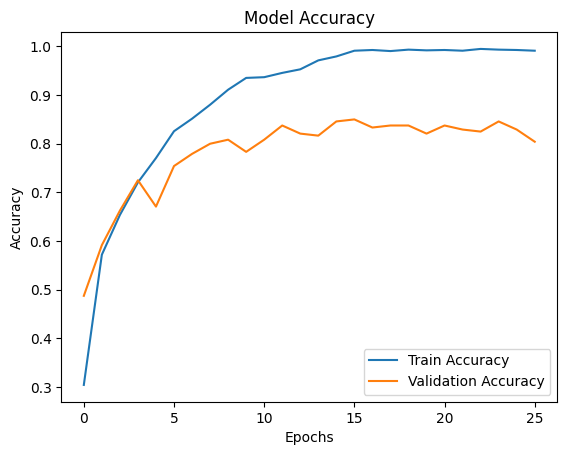

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8325 - loss: 0.7263
Test Loss: 0.7705931663513184
Test Accuracy: 0.8450000286102295


In [14]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = final_model.fit(train_data, train_labels, 
                epochs=50,
                validation_split=0.15,  
                batch_size=32,
                callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# evaluate the best model on the test set
test_loss, test_accuracy = final_model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

### Bayesian Approach

In [15]:
def objective(trial):
    # define hyperparameters to tune
    filters = [trial.suggest_int(f'filters_layer_{i+1}', 32, 128, step=16) for i in range(3)]
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    # init model
    model = Sequential()
    model.add(Conv2D(filters=filters[0], 
                     kernel_size=kernel_size, 
                     activation='relu', input_shape=(64, 64, 1))) # specify input for first layer
    model.add(MaxPooling2D(2))
    for i in range(1, 3):
        model.add(Conv2D(filters=filters[i], kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax')) # 4 classes

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # train the model
    model.fit(train_small, train_small_labels, 
              epochs=20, # fewer epochs for faster training
              validation_data=(val_data, val_labels), 
              callbacks=[early_stopping],
              verbose=0)
    # return the objective: accuracy
    return model.evaluate(test_data, test_labels, verbose=1)[1] 

# Initialize study
Bayes_study = optuna.create_study(direction='maximize')
Bayes_study.optimize(objective, n_trials=50)

[I 2024-12-05 12:44:42,898] A new study created in memory with name: no-name-0a69de25-bcb8-4ac8-a7b0-667ac49cb51a


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8019 - loss: 0.6255


[I 2024-12-05 12:45:20,558] Trial 0 finished with value: 0.7875000238418579 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 32, 'kernel_size': 4, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.00020312954041645217}. Best is trial 0 with value: 0.7875000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8236 - loss: 0.5552


[I 2024-12-05 12:47:24,322] Trial 1 finished with value: 0.8100000023841858 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 80, 'filters_layer_3': 96, 'kernel_size': 5, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.00011492920529149298}. Best is trial 1 with value: 0.8100000023841858.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8223 - loss: 0.6560


[I 2024-12-05 12:48:27,360] Trial 2 finished with value: 0.8199999928474426 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 80, 'filters_layer_3': 32, 'kernel_size': 3, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005271265649707385}. Best is trial 2 with value: 0.8199999928474426.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8351 - loss: 0.8406


[I 2024-12-05 12:49:00,210] Trial 3 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 32, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.0016746247755061435}. Best is trial 2 with value: 0.8199999928474426.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8275 - loss: 0.5701


[I 2024-12-05 12:49:31,266] Trial 4 finished with value: 0.8125 and parameters: {'filters_layer_1': 32, 'filters_layer_2': 64, 'filters_layer_3': 128, 'kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0004352840543439658}. Best is trial 2 with value: 0.8199999928474426.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6992 - loss: 0.8253


[I 2024-12-05 12:50:07,222] Trial 5 finished with value: 0.6675000190734863 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 32, 'filters_layer_3': 64, 'kernel_size': 5, 'dense_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.008257010116527417}. Best is trial 2 with value: 0.8199999928474426.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2310 - loss: 1.3931


[I 2024-12-05 12:50:23,126] Trial 6 finished with value: 0.2199999988079071 and parameters: {'filters_layer_1': 32, 'filters_layer_2': 80, 'filters_layer_3': 48, 'kernel_size': 5, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0062288571520683405}. Best is trial 2 with value: 0.8199999928474426.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8247 - loss: 0.6498


[I 2024-12-05 12:51:47,694] Trial 7 finished with value: 0.8274999856948853 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 64, 'filters_layer_3': 96, 'kernel_size': 5, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005538227714997991}. Best is trial 7 with value: 0.8274999856948853.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7969 - loss: 0.6120


[I 2024-12-05 12:52:25,887] Trial 8 finished with value: 0.7749999761581421 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 32, 'filters_layer_3': 32, 'kernel_size': 5, 'dense_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.00021480123939751183}. Best is trial 7 with value: 0.8274999856948853.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8105 - loss: 0.8288


[I 2024-12-05 12:53:30,127] Trial 9 finished with value: 0.8199999928474426 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 96, 'filters_layer_3': 96, 'kernel_size': 3, 'dense_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.001074696032473995}. Best is trial 7 with value: 0.8274999856948853.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7814 - loss: 1.1529


[I 2024-12-05 12:55:55,748] Trial 10 finished with value: 0.800000011920929 and parameters: {'filters_layer_1': 112, 'filters_layer_2': 128, 'filters_layer_3': 80, 'kernel_size': 4, 'dense_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0025346463742175794}. Best is trial 7 with value: 0.8274999856948853.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7888 - loss: 0.6975


[I 2024-12-05 12:57:40,756] Trial 11 finished with value: 0.7900000214576721 and parameters: {'filters_layer_1': 128, 'filters_layer_2': 112, 'filters_layer_3': 64, 'kernel_size': 3, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005433388482115213}. Best is trial 7 with value: 0.8274999856948853.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8211 - loss: 0.6850


[I 2024-12-05 12:58:52,708] Trial 12 finished with value: 0.8349999785423279 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 64, 'filters_layer_3': 80, 'kernel_size': 3, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000548551698795923}. Best is trial 12 with value: 0.8349999785423279.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8400 - loss: 0.5727


[I 2024-12-05 12:59:54,460] Trial 13 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 48, 'filters_layer_3': 96, 'kernel_size': 4, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0009598691350610239}. Best is trial 12 with value: 0.8349999785423279.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8175 - loss: 0.6849


[I 2024-12-05 13:01:05,119] Trial 14 finished with value: 0.8050000071525574 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 48, 'filters_layer_3': 80, 'kernel_size': 4, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0025852847245811128}. Best is trial 12 with value: 0.8349999785423279.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8402 - loss: 0.8374


[I 2024-12-05 13:02:28,640] Trial 15 finished with value: 0.8374999761581421 and parameters: {'filters_layer_1': 128, 'filters_layer_2': 48, 'filters_layer_3': 128, 'kernel_size': 3, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0012418628192432132}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8159 - loss: 0.7196


[I 2024-12-05 13:03:37,237] Trial 16 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 128, 'filters_layer_2': 48, 'filters_layer_3': 128, 'kernel_size': 3, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.004223694064074638}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8117 - loss: 0.8858


[I 2024-12-05 13:05:04,369] Trial 17 finished with value: 0.8075000047683716 and parameters: {'filters_layer_1': 112, 'filters_layer_2': 96, 'filters_layer_3': 112, 'kernel_size': 3, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0011188140132569033}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8040 - loss: 0.5653


[I 2024-12-05 13:06:04,657] Trial 18 finished with value: 0.8025000095367432 and parameters: {'filters_layer_1': 112, 'filters_layer_2': 48, 'filters_layer_3': 64, 'kernel_size': 3, 'dense_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0002479087554934402}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8197 - loss: 0.6346


[I 2024-12-05 13:07:31,516] Trial 19 finished with value: 0.8274999856948853 and parameters: {'filters_layer_1': 128, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 3, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0003343541332915816}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8045 - loss: 0.7717


[I 2024-12-05 13:09:29,660] Trial 20 finished with value: 0.8025000095367432 and parameters: {'filters_layer_1': 112, 'filters_layer_2': 96, 'filters_layer_3': 80, 'kernel_size': 3, 'dense_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000848700984543999}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7488 - loss: 0.6816


[I 2024-12-05 13:10:13,191] Trial 21 finished with value: 0.7749999761581421 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 48, 'filters_layer_3': 128, 'kernel_size': 4, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0017800096756319704}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7902 - loss: 0.5654


[I 2024-12-05 13:10:51,741] Trial 22 finished with value: 0.7925000190734863 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 48, 'filters_layer_3': 96, 'kernel_size': 4, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0007135523770879373}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8362 - loss: 0.6971


[I 2024-12-05 13:12:00,226] Trial 23 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0010394813042899078}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7989 - loss: 1.0221


[I 2024-12-05 13:12:48,290] Trial 24 finished with value: 0.7975000143051147 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 32, 'filters_layer_3': 48, 'kernel_size': 3, 'dense_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.0018367160403517497}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8135 - loss: 0.8358


[I 2024-12-05 13:13:35,907] Trial 25 finished with value: 0.8224999904632568 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 48, 'filters_layer_3': 96, 'kernel_size': 3, 'dense_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0012696581311845906}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7385 - loss: 0.7269


[I 2024-12-05 13:14:42,024] Trial 26 finished with value: 0.7524999976158142 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 64, 'filters_layer_3': 80, 'kernel_size': 4, 'dense_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0034324761358840083}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8035 - loss: 0.6328


[I 2024-12-05 13:15:50,294] Trial 27 finished with value: 0.8100000023841858 and parameters: {'filters_layer_1': 128, 'filters_layer_2': 48, 'filters_layer_3': 128, 'kernel_size': 3, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000385151013246445}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7942 - loss: 0.5712


[I 2024-12-05 13:16:59,360] Trial 28 finished with value: 0.7900000214576721 and parameters: {'filters_layer_1': 112, 'filters_layer_2': 32, 'filters_layer_3': 64, 'kernel_size': 4, 'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.00012606592267285445}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8285 - loss: 0.5627


[I 2024-12-05 13:17:34,234] Trial 29 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.000726808336631817}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8225 - loss: 0.5093


[I 2024-12-05 13:18:18,139] Trial 30 finished with value: 0.824999988079071 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 80, 'filters_layer_3': 80, 'kernel_size': 3, 'dense_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.00030732618041513944}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8056 - loss: 0.5091


[I 2024-12-05 13:18:52,985] Trial 31 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0006891456685833401}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7976 - loss: 0.6984


[I 2024-12-05 13:19:43,665] Trial 32 finished with value: 0.8075000047683716 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 32, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0014229231115557269}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8285 - loss: 0.5686


[I 2024-12-05 13:20:30,619] Trial 33 finished with value: 0.8224999904632568 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 48, 'filters_layer_3': 96, 'kernel_size': 4, 'dense_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0007907048891079453}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8277 - loss: 0.6263


[I 2024-12-05 13:22:09,748] Trial 34 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 64, 'filters_layer_3': 128, 'kernel_size': 5, 'dense_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006144722250419409}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8248 - loss: 0.5639


[I 2024-12-05 13:23:06,886] Trial 35 finished with value: 0.8100000023841858 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 32, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.00043769530463829245}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8183 - loss: 0.6694


[I 2024-12-05 13:23:39,945] Trial 36 finished with value: 0.8149999976158142 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 48, 'filters_layer_3': 96, 'kernel_size': 3, 'dense_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008292969607164823}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8426 - loss: 0.7689


[I 2024-12-05 13:25:39,400] Trial 37 finished with value: 0.8199999928474426 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 80, 'filters_layer_3': 128, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001527905542094026}. Best is trial 15 with value: 0.8374999761581421.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8546 - loss: 0.4905


[I 2024-12-05 13:26:39,647] Trial 38 finished with value: 0.8500000238418579 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0004842926262897396}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8264 - loss: 0.5377


[I 2024-12-05 13:27:35,190] Trial 39 finished with value: 0.8299999833106995 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 80, 'filters_layer_3': 128, 'kernel_size': 3, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00044313123817441333}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8268 - loss: 0.8521


[I 2024-12-05 13:28:35,784] Trial 40 finished with value: 0.824999988079071 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 64, 'filters_layer_3': 96, 'kernel_size': 5, 'dense_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.002310735065398148}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8425 - loss: 0.7505


[I 2024-12-05 13:29:37,451] Trial 41 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.000941831558716657}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8133 - loss: 0.5039


[I 2024-12-05 13:30:23,574] Trial 42 finished with value: 0.8224999904632568 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 48, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0005068667306281965}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8440 - loss: 0.4850


[I 2024-12-05 13:31:14,277] Trial 43 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 48, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001484160983077343}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8147 - loss: 0.5325


[I 2024-12-05 13:31:58,975] Trial 44 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 80, 'kernel_size': 4, 'dense_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.00029274992408313675}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8441 - loss: 0.7587


[I 2024-12-05 13:33:23,322] Trial 45 finished with value: 0.8399999737739563 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 80, 'filters_layer_3': 96, 'kernel_size': 4, 'dense_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006458722661512328}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8081 - loss: 0.5190


[I 2024-12-05 13:34:43,644] Trial 46 finished with value: 0.8025000095367432 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 80, 'filters_layer_3': 96, 'kernel_size': 5, 'dense_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006088736255749939}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8452 - loss: 0.5189


[I 2024-12-05 13:36:36,383] Trial 47 finished with value: 0.8324999809265137 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 96, 'filters_layer_3': 96, 'kernel_size': 4, 'dense_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00023697028300287588}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8134 - loss: 0.8002


[I 2024-12-05 13:37:40,399] Trial 48 finished with value: 0.8174999952316284 and parameters: {'filters_layer_1': 80, 'filters_layer_2': 80, 'filters_layer_3': 80, 'kernel_size': 3, 'dense_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.001194188873688251}. Best is trial 38 with value: 0.8500000238418579.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8290 - loss: 0.5220


[I 2024-12-05 13:38:43,134] Trial 49 finished with value: 0.8125 and parameters: {'filters_layer_1': 96, 'filters_layer_2': 64, 'filters_layer_3': 64, 'kernel_size': 3, 'dense_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00018707826849092294}. Best is trial 38 with value: 0.8500000238418579.


Best Hyperparameters:
{'filters_layer_1': 64, 'filters_layer_2': 64, 'filters_layer_3': 112, 'kernel_size': 4, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0004842926262897396}
Best Accuracy:
0.8500000238418579


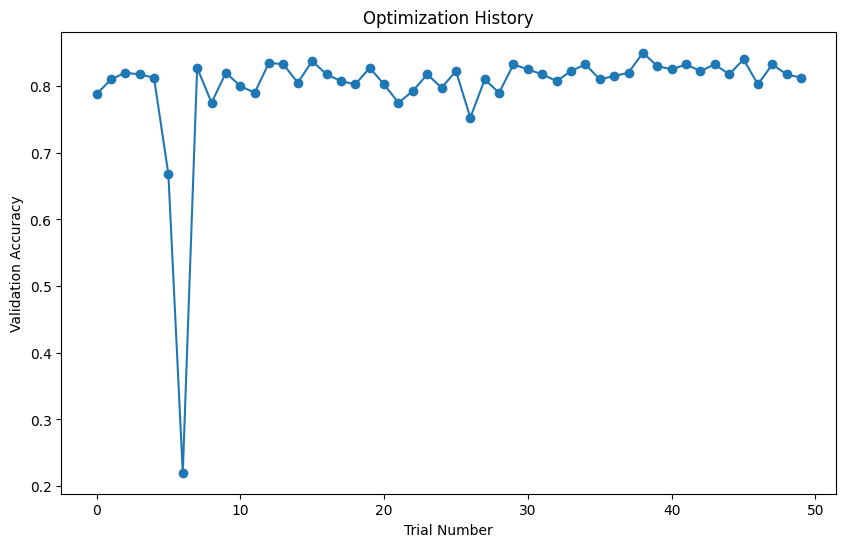

In [16]:
# Print the best hyperparameters and the best accuracy
print("Best Hyperparameters:")
print(Bayes_study.best_params)
print("Best Accuracy:")
print(Bayes_study.best_value)

# Extract data from the study
trials = Bayes_study.trials
values = [trial.value for trial in trials]
trial_numbers = [trial.number for trial in trials]

# Plot optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, values, marker='o')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.title('Optimization History')
plt.show()

In [17]:
# build best bayesian model

best_bayes_model = Bayes_study.best_params
bayes_hp = kt.HyperParameters()

for key, value in best_bayes_model.items(): # iterate through the best hyperparameters and set them
    bayes_hp.Fixed(key, value)

bayes_model = tuner.hypermodel.build(bayes_hp)
bayes_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_bayes_model['learning_rate']), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train best bayesian model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True) # callback to prevent overfitting
bayes_history = bayes_model.fit(train_data, train_labels, 
                          epochs=50, validation_split=0.2, 
                          batch_size=32, callbacks=[early_stopping])

# evaluate best bayesian model
bayes_test_loss, bayes_test_accuracy = bayes_model.evaluate(test_data, test_labels)
print(f"Test Loss: {bayes_test_loss}")
print(f"Test Accuracy: {bayes_test_accuracy}")

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2397 - loss: 1.3894 - val_accuracy: 0.2875 - val_loss: 1.3503
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3801 - loss: 1.3266 - val_accuracy: 0.4344 - val_loss: 1.1962
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4843 - loss: 1.1582 - val_accuracy: 0.6000 - val_loss: 1.0387
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5854 - loss: 1.0077 - val_accuracy: 0.6313 - val_loss: 0.9790
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6359 - loss: 0.9179 - val_accuracy: 0.6469 - val_loss: 0.9291
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6836 - loss: 0.8383 - val_accuracy: 0.6562 - val_loss: 0.8812
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7091 - loss: 0.7601 - val_accuracy: 0.6781 - val_loss: 0.8483
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7284 - loss: 0.6971 - val_accuracy: 0.7125 - v

## Comparing Bayesian versus Hyperband Tuning

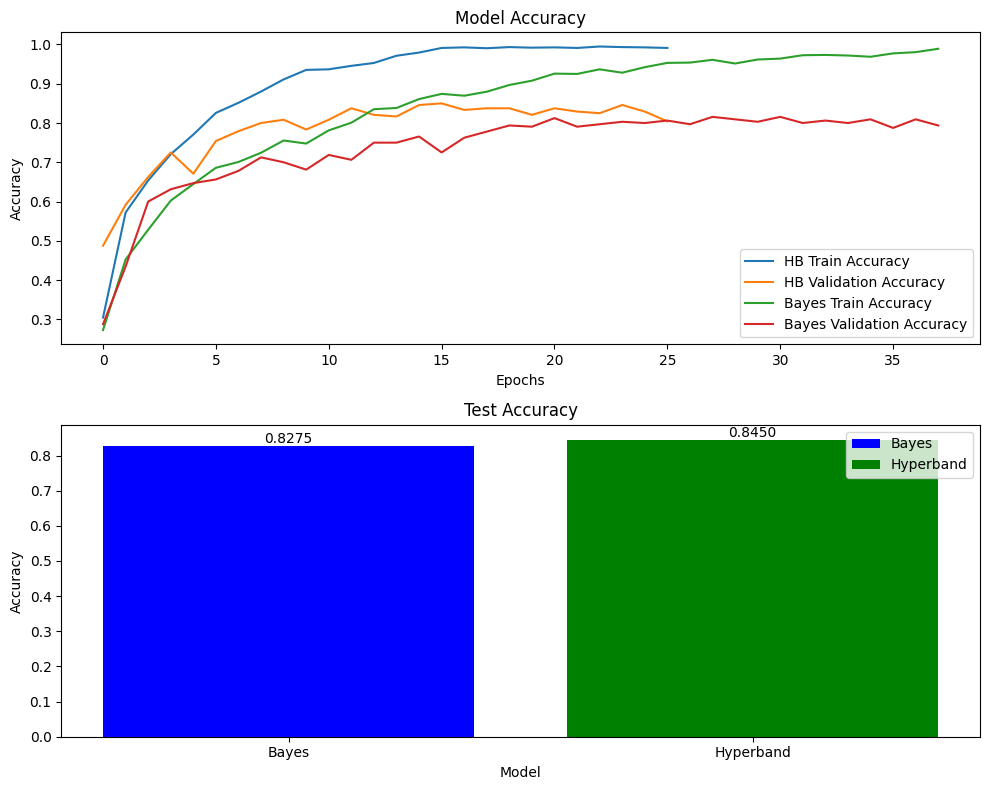

In [18]:
# plot the accuracy and loss of the two models and the test accuracy of the two models
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(history.history['accuracy'], label='HB Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='HB Validation Accuracy')
ax[0].plot(bayes_history.history['accuracy'], label='Bayes Train Accuracy')
ax[0].plot(bayes_history.history['val_accuracy'], label='Bayes Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

bars = ax[1].bar(['Bayes', 'Hyperband'], 
                 [bayes_test_accuracy, test_accuracy], 
                 color = ['blue', 'green'], 
                 label = ['Bayes', 'Hyperband'])
for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')
ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()